# Import Packages

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Get Path Factor

Altavilla et al. (2019) find four factors in market perceptions of ECB policy communication, I focus on the path factor, capturing the effect forward guidance and on the Delphic window, which lasted until 2014. The data is available [here](http://refet.bilkent.edu.tr/research.html).

In [2]:
# Aggregate Path Factor to Quarterly Frequency and Convert to Percentage Points
dfPath = pd.read_csv('dataset_con.csv', usecols=[7, 9])
dfPath.index = dfPath['Date']
dfPath = dfPath.drop('Date', axis=1)
dfPath.columns = ['Path']
dfPath = dfPath/100
dfPath = dfPath.loc[dfPath.index < '2014-01-01']
dfPath.index = pd.to_datetime(dfPath.index)
dfPath = dfPath.resample('Q').mean()
dfPath.index = pd.PeriodIndex(dfPath.index, freq='Q')
dfPath.head()

,Path
Date,
2002Q1,-0.007478
2002Q2,0.021223
2002Q3,-0.021127
2002Q4,0.008067
2003Q1,-0.009132


This transformation introduces no bias as the monetary policy surprises captured by the factor are orthogonal to each other.

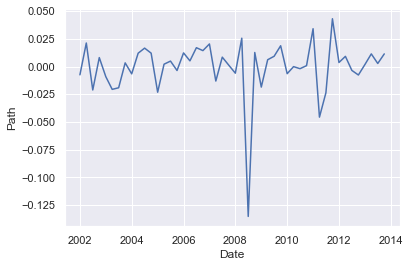

In [3]:
sns.lineplot(x=dfPath.index.to_timestamp(), y=dfPath['Path']);

In [4]:
# Test Stationarity
adfuller(dfPath)

(-8.436753780832577,
 1.808012933744221e-13,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 -158.82134445996172)

The null hypothesis that a unit root is present in a time series is rejected, therefore the series is stationary.

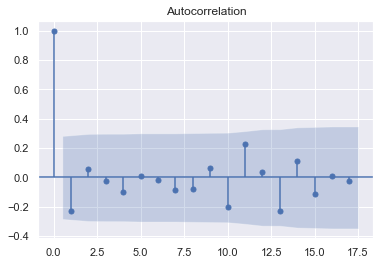

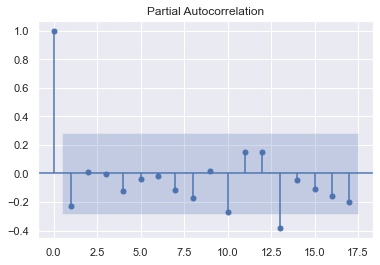

In [5]:
# Autocovariance and Partial Autocovariance
plot_acf(dfPath), plot_pacf(dfPath);

The autocovariance and partial autocovariance functions (ACF/PACF) can be used to determine the order of the ARIMA process. The process appears to have no autoregressive (AR) or moving average (MA) component. I investigate the 13th significant lag in the PACF by estimating all ARIMA models with 0$\leq$p$\leq$15 and 0$\leq$q$\leq$15, where p and q are respectively the AR and MA order, and picking the optimal specification based on the Bayesian information criterion (BIC).

In [6]:
print('Mean= ', dfPath['Path'].mean(), '≃ 0')
auto_arima(dfPath, start_p=0, start_q=0, max_p=15, max_q=15, information_criterion='bic')

Mean=  -0.0004679249060185872 ≃ 0


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

The path factor is already white noise. 

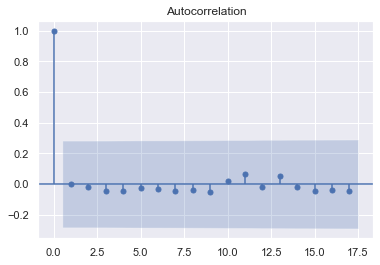

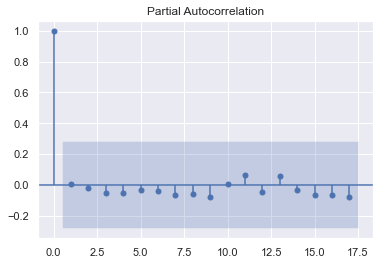

In [7]:
plot_acf(dfPath**2), plot_pacf(dfPath**2);

As there is no autocorrelation in the variance no ARCH/GARCH extension is needed.

In [8]:
# Save DataFrame
dfPath.to_pickle('Path.pkl')